Here, we examine functional sensitivity of the structure model on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.influence_lib 

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Draw data

In [3]:
data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz'
data = np.load(data_file)

# the observations
g_obs = np.array(data['g_obs'], dtype = int)

n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# the ground truth 
true_ind_admix_propn = data['true_ind_admix_propn']

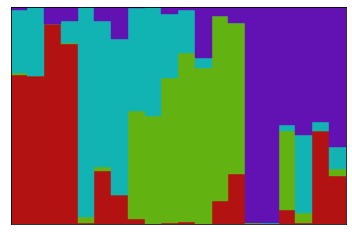

In [4]:
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

# Get prior

In [5]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


In [6]:
print(prior_params_dict)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [7]:
k_approx = 15

In [8]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [9]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 15, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (20, 14) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (20, 14) (lb=0.0001, ub=inf)


# Optimize

### Initialize with CAVI

In [11]:
_, vb_params_paragami = \
        structure_model_lib.\
            get_vb_params_paragami_object(n_obs, 
                                          n_loci,
                                          k_approx,
                                          use_logitnormal_sticks = True, 
                                          seed = 4345)
    
vb_params_dict = \
    s_optim_lib.initialize_with_cavi(g_obs, 
                         vb_params_paragami, 
                         prior_params_dict, 
                         gh_loc, gh_weights, 
                         print_every = 20, 
                         max_iter = 100, 
                         seed = 4345)

Compiling cavi functions ...
CAVI compile time: 5.25sec

 running CAVI ...
iteration [20]; kl:1840.060089; elapsed: 0.2128secs
iteration [40]; kl:1830.746473; elapsed: 0.1868secs
iteration [60]; kl:1829.135684; elapsed: 0.1028secs
iteration [80]; kl:1828.520338; elapsed: 0.1003secs
Done. Warning, max iterations reached. 
final KL: 1828.283570
Elapsed: 99 steps in 0.70 seconds
Stick conversion time: 1.662secs


### Run a few steps of L-BFGS

In [12]:
# optimize with preconditioner 
vb_opt_dict, vb_opt, out, precond_objective = \
    s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                        vb_params_dict, 
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc, gh_weights)

compiling preconditioned objective ... 
done. Elasped: 50.5179
init kl: 1834.026952
iteration [20]; kl:1833.668465; elapsed: 0.875secs
iteration [21]; kl:1833.668464; elapsed: 0.125secs
lbfgs converged successfully
done. Elapsed 2.5676


# Check out the fit

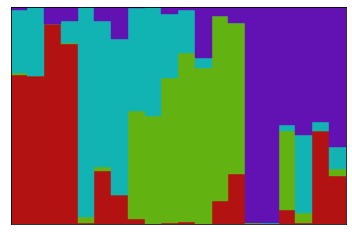

In [13]:
# truth
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

Text(0.5, 0, 'individual')

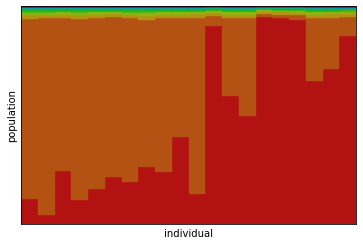

In [14]:
# estimated 

e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(e_ind_admix, axarr);

plt.ylabel('population')
plt.xlabel('individual')

# Set up linear response derivatives

In [15]:
# set up objective functions

# this just returns the KL at epsilon = 0 
# (no perturbation)
# NOTE this function doesn't actually depend on epsilon
# we can do this and set log_phi later because 
# the perturbation is multiplicative 
# (so the hessian at epsilon = 0 does not depend on the perturbation)
get_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: structure_model_lib.get_kl(g_obs, 
                                            params,
                                            prior_params_dict, 
                                            gh_loc,
                                            gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)


# this is just a place holder for a null perturbation
# will set this properly later
hyper_par_objective_fun = lambda params, epsilon: 0.


In [16]:
# set up linear approximation class
epsilon0 = np.array([0.])

epsilon_sens = \
    HyperparameterSensitivityLinearApproximation(
        objective_fun = get_vb_loss, 
        opt_par_value = vb_opt, 
        hyper_par_value0 = epsilon0, 
        hyper_par_objective_fun = hyper_par_objective_fun)


Compiling ...
Compile time: 82.8511sec



# Compute influence function

In [17]:
# the influence function
influence_operator = influence_lib.InfluenceOperator(vb_opt, 
                           vb_params_paragami, 
                           epsilon_sens.hessian_solver,
                           prior_params_dict['dp_prior_alpha'], 
                           stick_key = 'ind_admix_params')

### Define posterior quantity of interest

In [20]:
def g(vb_free_params, vb_params_paragami): 
    
    # key for random sampling. 
    # this is fixed! so all standard normal 
    # samples used in computing the posterior quantity 
    key = jax.random.PRNGKey(0)
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                       key = key,
                                                       n_samples = 1000)

In [21]:
get_grad_g = jax.jacobian(g, argnums = 0)
grad_g = get_grad_g(vb_opt, vb_params_paragami)

### worst-case influence

In [23]:
influence_fun = lambda logit_v : influence_operator.get_influence(logit_v, grad_g)

In [27]:
logit_v_grid = np.linspace(-10, 10, 200)

In [28]:
worst_case_pert = influence_lib.WorstCasePerturbation(influence_fun, 
                                                      logit_v_grid)

inverting hessian ...
done.


### Plot influence function

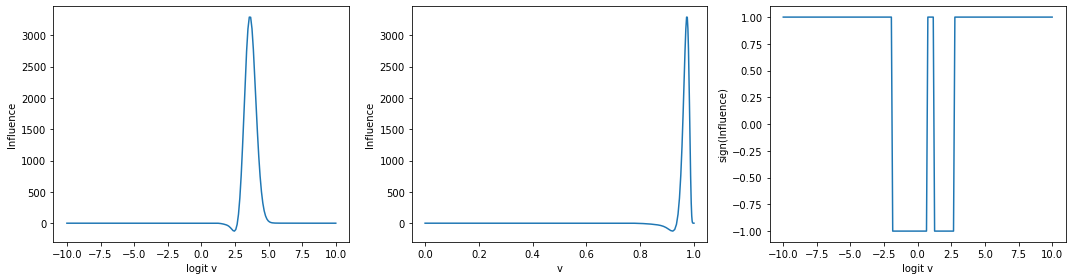

In [30]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 
ax[0].plot(worst_case_pert.logit_v_grid, worst_case_pert.influence_grid)
ax[0].set_xlabel('logit v')
ax[0].set_ylabel('Influence')

ax[1].plot(worst_case_pert.v_grid, worst_case_pert.influence_grid)
ax[1].set_xlabel('v')
ax[1].set_ylabel('Influence')

ax[2].plot(worst_case_pert.logit_v_grid, np.sign(worst_case_pert.influence_grid))
ax[2].set_xlabel('logit v')
ax[2].set_ylabel('sign(Influence)')

fig.tight_layout()

# Define prior perturbation

In [31]:
# just for plotting only! 
# saves some time in computing the influence function
# by doing a setp function interpolation
def influence_fun_interp(logit_v): 
    # find index of logit_v_grid 
    # closest (on the left) to logit_v
    indx = np.searchsorted(worst_case_pert.logit_v_grid, logit_v)
    
    # return the influence function at those points
    return worst_case_pert.influence_grid[indx]

# define log phi
def log_phi(logit_v):
    return(np.sign(influence_fun_interp(logit_v)))

In [32]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['dp_prior_alpha'],
                                log_phi = log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.197675e-03
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.683242e-01
  warnings.warn(


Text(0.5, 1.0, 'Priors in logit space')

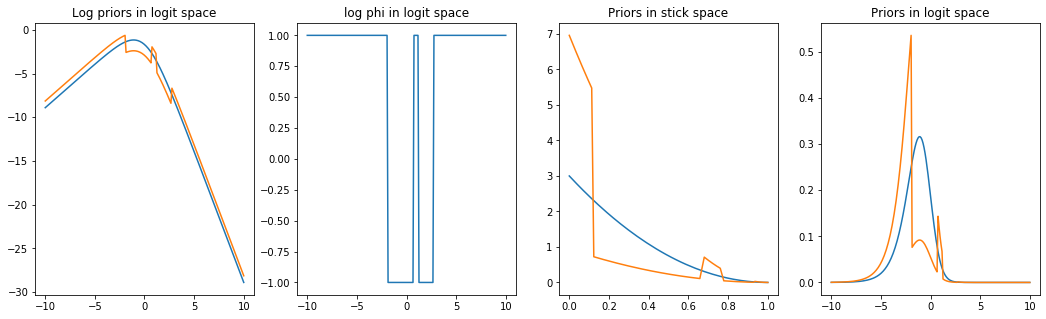

In [33]:
prior_perturbation.set_epsilon(1.0)

v_grid = sp.special.expit(logit_v_grid)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [34]:
def get_e_log_perturbation(means, infos, epsilon): 
    return epsilon * worst_case_pert.get_e_log_linf_perturbation(means.flatten(), 
                                                                 infos.flatten())

In [35]:
def _hyper_par_objective_fun(params, epsilon): 
    
    means = params['ind_admix_params']['stick_means']
    infos = params['ind_admix_params']['stick_infos']
    
    return - get_e_log_perturbation(means, infos, epsilon)

# the terms of the KL objective that depend on epsilon 
hyper_par_objective_fun = paragami.FlattenFunctionInput(_hyper_par_objective_fun,
                                                        argnums=0, 
                                                        patterns=vb_params_paragami,
                                                        free = True)


# Get derivative for prior perturbation

In [36]:
epsilon_sens._set_cross_hess(hyper_par_objective_fun)
epsilon_sens._set_dinput_dhyper()

In [37]:
epsilon = 1.0
print('Epsilon: ', epsilon)

lr_vb_free_params = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('Predicted differences: ', np.linalg.norm(lr_vb_free_params - vb_opt))

Epsilon:  1.0
Predicted differences:  29.33310530359622


In [38]:
vb_pert_pred_dict = vb_params_paragami.fold(lr_vb_free_params, free = True)

# Re-optimize

In [39]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [41]:
s_optim_lib.run_preconditioned_lbfgs?

In [44]:
vb_pert_dict, vb_opt_pert, _, _ = \
    s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                                         new_init_dict,
                                        vb_params_paragami,
                                        prior_params_dict,
                                        gh_loc = gh_loc,
                                        gh_weights = gh_weights,
                                        e_log_phi = lambda means, infos : \
                                                           get_e_log_perturbation(means, infos, epsilon))


compiling preconditioned objective ... 
done. Elasped: 49.9138
init kl: 1926.622022
iteration [20]; kl:1813.336151; elapsed: 0.927secs
iteration [36]; kl:1810.226084; elapsed: 0.767secs
lbfgs converged successfully
done. Elapsed 2.2304


In [45]:
np.linalg.norm(vb_opt_pert - vb_opt)

DeviceArray(21.57260353, dtype=float64)

### compare

In [46]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot((lr_vb_free_params - vb_opt), 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


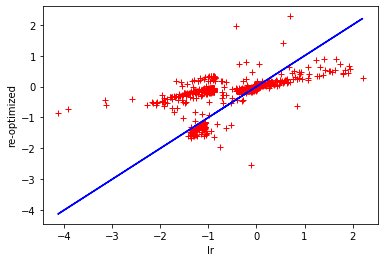

In [47]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [48]:
print('init number of cluster: ', g(vb_opt, vb_params_paragami))

print('pert number of cluster: ', g(vb_opt_pert, vb_params_paragami))
print('lr number of cluster: ', g(lr_vb_free_params, vb_params_paragami))

init number of cluster:  2.9498084493365098
pert number of cluster:  2.7576587342199406
lr number of cluster:  2.340032774010245


# Fit for a range of epsilon

In [49]:
epsilon_list = np.linspace(0, 1, 8) ** 2 # Square to get more points close to 0
print(epsilon_list)

[0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [53]:
def refit_with_epsilon(epsilon, new_init_dict):
    # sets new epsilon, returns new vb optimum
    
    vb_opt = s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                                         new_init_dict,
                                        vb_params_paragami,
                                        prior_params_dict,
                                        gh_loc = gh_loc,
                                        gh_weights = gh_weights,
                                        e_log_phi = lambda means, infos : \
                                                           get_e_log_perturbation(means, infos, epsilon))[1]
        
    return vb_opt


In [54]:
print('epsilons: ', epsilon_list)

epsilons:  [0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [55]:
vb_pert_list = []
for epsilon in epsilon_list: 
    print('\n re-optimzing with epsilon = ', epsilon)
    
    vb_pert_list.append(refit_with_epsilon(epsilon, new_init_dict))



 re-optimzing with epsilon =  0.0
compiling preconditioned objective ... 
done. Elasped: 50.305
init kl: 1833.668464
iteration [1]; kl:1833.668463; elapsed: 0.131secs
lbfgs converged successfully
done. Elapsed 0.6763

 re-optimzing with epsilon =  0.02040816326530612
compiling preconditioned objective ... 
done. Elasped: 51.1537
init kl: 1835.565475
iteration [17]; kl:1835.506837; elapsed: 0.799secs
lbfgs converged successfully
done. Elapsed 1.3442

 re-optimzing with epsilon =  0.08163265306122448
compiling preconditioned objective ... 
done. Elasped: 49.903
init kl: 1841.256509
iteration [20]; kl:1840.329512; elapsed: 0.840secs
iteration [22]; kl:1840.329505; elapsed: 0.167secs
lbfgs converged successfully
done. Elapsed 1.5678

 re-optimzing with epsilon =  0.18367346938775508
compiling preconditioned objective ... 
done. Elasped: 51.4761
init kl: 1850.741566
iteration [20]; kl:1846.120270; elapsed: 0.879secs
iteration [35]; kl:1846.118742; elapsed: 0.719secs
lbfgs converged success

# Check free parameters

In [56]:
lr_list = []

for epsilon in epsilon_list: 
    
    # get linear response
    lr_list.append(epsilon_sens.predict_opt_par_from_hyper_par(epsilon))


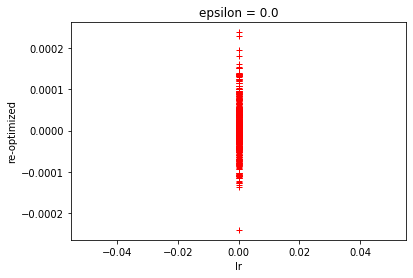

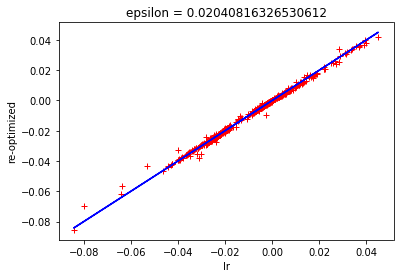

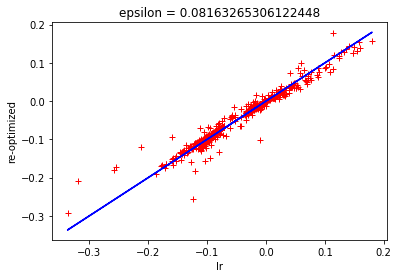

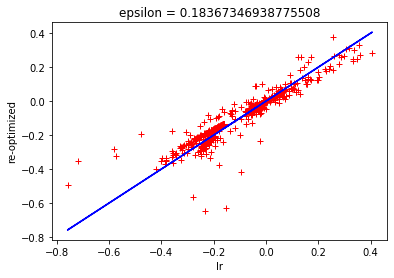

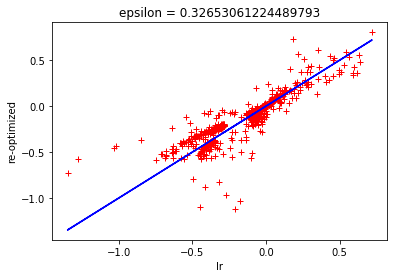

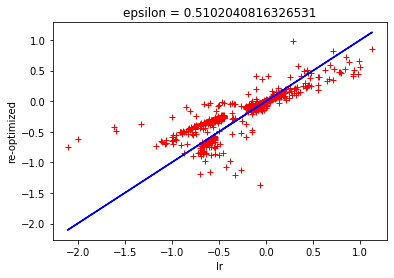

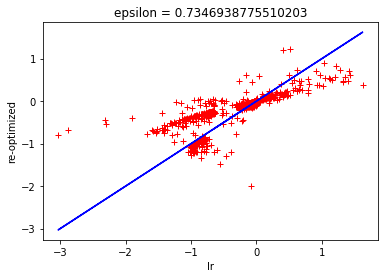

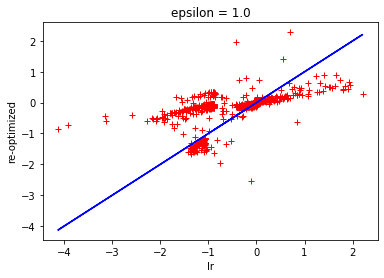

In [57]:
for i in range(len(epsilon_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('epsilon = {}'.format(epsilon_list[i]))


# Number of clusters

In [58]:
lr_e_num_clusters_vec = onp.zeros(len(epsilon_list))
refit_e_num_clusters_vec = onp.zeros(len(epsilon_list))

for i in range(len(epsilon_list)): 
        
    # get number of clusters
    refit_e_num_clusters_vec[i] = g(vb_pert_list[i], vb_params_paragami)
    lr_e_num_clusters_vec[i] = g(lr_list[i], vb_params_paragami)


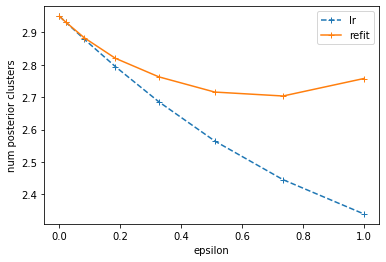

In [59]:
plt.plot(epsilon_list, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))
